# <center>**IROS Implementation**<center>

**Libraries**

In [1]:
import numpy as np
from scipy.signal import correlate

import maskpattern as mp
import plot_module as plot
import balancing as bal
import stats

np.set_printoptions(precision=2, suppress=False)

In [ ]:
import importlib
importlib.reload(stats)

## **2D URA/MURA Masks with PCFOV**

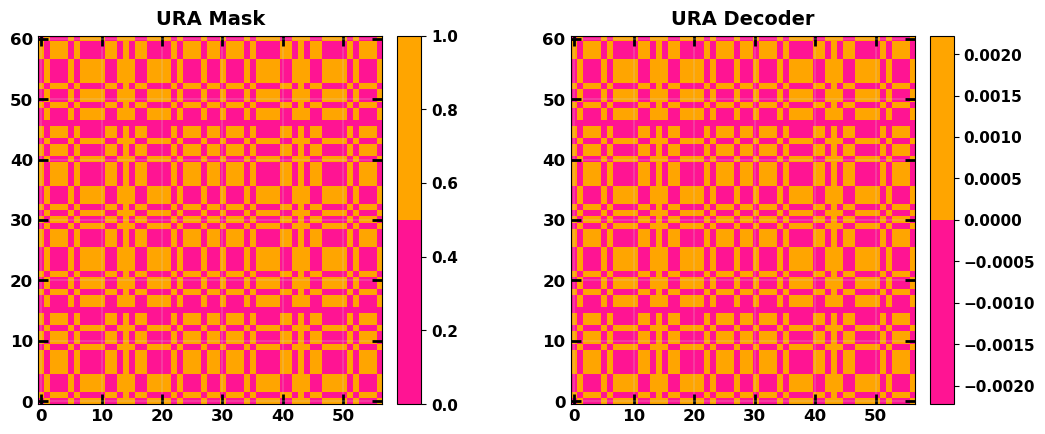

In [2]:
ura = mp.URAMaskPattern(4)
ura_pattern2D, ura_decoder2D = ura.basic_pattern, ura.basic_decoder

n, m = ura_pattern2D.shape
pad_n, pad_m = (n - 1)//2, (m - 1)//2

mask = np.pad(ura_pattern2D, pad_width=((pad_n, pad_n), (pad_m, pad_m)), mode='wrap')
decoder = np.pad(ura_decoder2D, pad_width=((pad_n, pad_n), (pad_m, pad_m)), mode='wrap')

plot.image_plot([mask, decoder],
                ["URA Mask", "URA Decoder"])

In [3]:
import collections.abc as c

def sky_image_simulation(sky_image_shape: tuple[int, int],
                         sources_flux: c.Sequence[int],
                         sources_pos: None | c.Sequence[tuple[int, int]] = None,
                         sky_background_rate: None | int = None,
                         ) -> tuple[c.Sequence, None | c.Sequence]:
    """Simulates the sky image given the sources flux."""

    sky_image = np.zeros(sky_image_shape)

    if sources_pos is None:
        sources_pos = [(np.random.randint(0, sky_image_shape[0]), np.random.randint(0, sky_image_shape[1]))
                       for _ in range(len(sources_flux))]

    # assign fluxes to point-like sources
    for i, pos in enumerate(sources_pos):
        sky_image[pos[0], pos[1]] = sources_flux[i]

    # add sky background
    if sky_background_rate is not None:
        sky_background = np.random.poisson(sky_background_rate, sky_image_shape)
        sky_image += sky_background
    else:
        sky_background = None
    
    return sky_image, sky_background, sources_pos

### **Sky Image with Sources in the FCFOV**

- Let's first simulate a sky image and then perform the cross-correlation to obtain the sky reconstruction

- For now, I will consider only sources in the FCFOV (the sky image will comprehend the PCFOV)

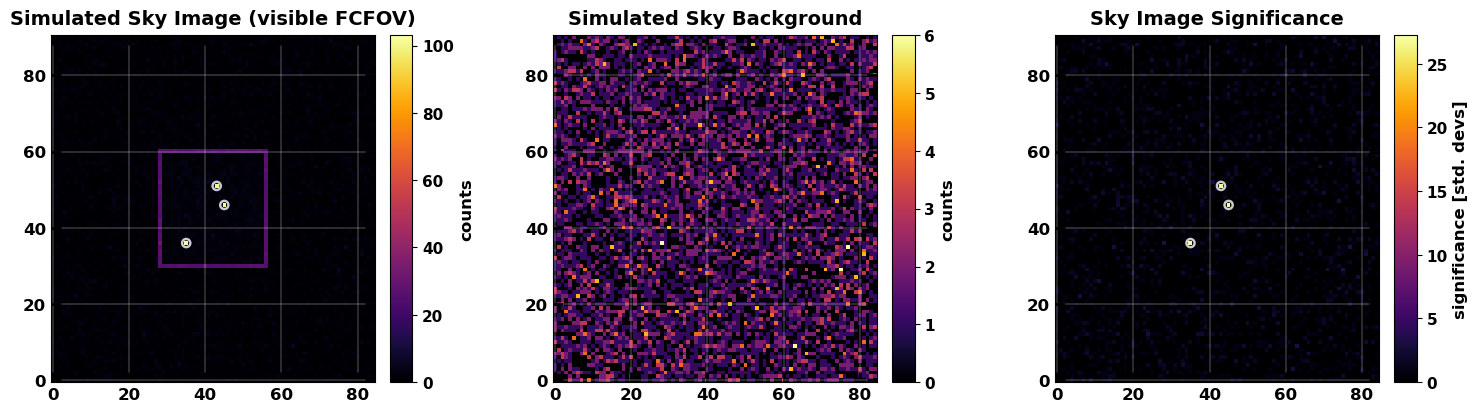

In [12]:
h, v = n - 1, m - 1
sky_shape = (n + 2*h, m + 2*v)

sources_flux = np.array([100, 100, 100])
sources_pos = [(n + 5, m + 6), (n + 15, m + 16), (h + n - 10, v + m - 14)]
sky_background_rate = 1

sky_image, sky_background, sources_pos = sky_image_simulation(sky_shape, sources_flux, sources_pos, sky_background_rate)
sky_significance = stats.significance(sky_image, sky_background_rate)

highlight_fcfov = True
if highlight_fcfov:
    base = np.ones((n - 2, m - 2))
    c_edge = np.pad(base, pad_width=[(1, 1), (1, 1)], constant_values=sources_flux.max()//4)

    sky_image_wfcfov = sky_image.copy()
    sky_image_wfcfov[h : -h, v : -v] += c_edge

    plot.image_plot([sky_image_wfcfov, sky_background, sky_significance],
                    ["Simulated Sky Image (visible FCFOV)", "Simulated Sky Background", "Sky Image Significance"],
                    cbarlabel=["counts", "counts", "significance [std. devs]"], 
                    cbarcmap=["inferno"]*3,
                    simulated_sources=[sources_pos, None, sources_pos])

else:
    plot.image_plot([sky_image, sky_background],
                    ["Simulated Sky Image", "Simulated Sky Background"],
                    cbarcmap=["inferno", "inferno"],
                    simulated_sources=[sources_pos, None])

/tmp/ipykernel_26521/1279592809.py:13: RuntimeWarning: invalid value encountered in sqrt
  snr = bal_sky_reconstruction/np.sqrt(balskyrec_var + 1e-8)


S_hat[0] - S[0]: 0.10375649591676961
STD_S_hat[0]: 2.9154240825327875

S_hat[1] - S[1]: 3.435238802276899
STD_S_hat[1]: 2.9154221035515167

S_hat[2] - S[2]: 0.3907399158634064
STD_S_hat[2]: 2.91542553655443



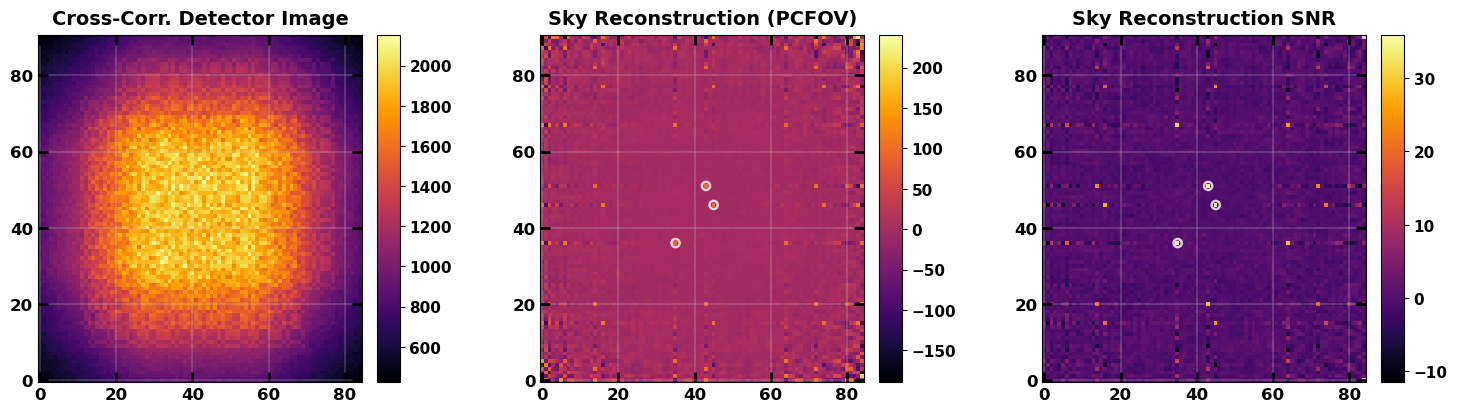

In [13]:
cc_detector_image = correlate(mask, sky_image, mode='full')[h : -h, v : -v]
fcfov_detector_image = cc_detector_image[h : -h, v : -v]

bulk_array = np.ones(fcfov_detector_image.shape)
balancing = bal.BalancedSkyReconstruction_Goldwurm(mask, decoder, bulk_array)
bal_sky_reconstruction, balskyrec_var = balancing.balanced_sky_reconstruction(fcfov_detector_image)

threshold = 300
post_bal_sky_reconstruction = bal_sky_reconstruction.copy()
post_bal_sky_reconstruction[bal_sky_reconstruction > threshold] = 0     # remove artifacts
post_bal_sky_reconstruction[bal_sky_reconstruction < -threshold] = 0

snr = bal_sky_reconstruction/np.sqrt(balskyrec_var + 1e-8)

for idx, pos in enumerate(sources_pos):
    print(f"S_hat[{idx}] - S[{idx}]: {bal_sky_reconstruction[*pos] - sky_image[*pos]}\n"
          f"STD_S_hat[{idx}]: {np.sqrt(balskyrec_var[*pos])}\n")

plot.image_plot([cc_detector_image, post_bal_sky_reconstruction, snr],
                ["Cross-Corr. Detector Image", "Sky Reconstruction (PCFOV)", "Sky Reconstruction SNR"],
                cbarcmap=["inferno"]*3,
                simulated_sources=[None, sources_pos, sources_pos])

**First Iteration**

- Let's start identifying the most brilliant source in the sky image reconstructed by cross-correlation.

- To achieve this we must first set a significance threshold (before setting a threshold it is better to check the normality of the reconstructed sky, as in `variance_SNR.ipynb`)

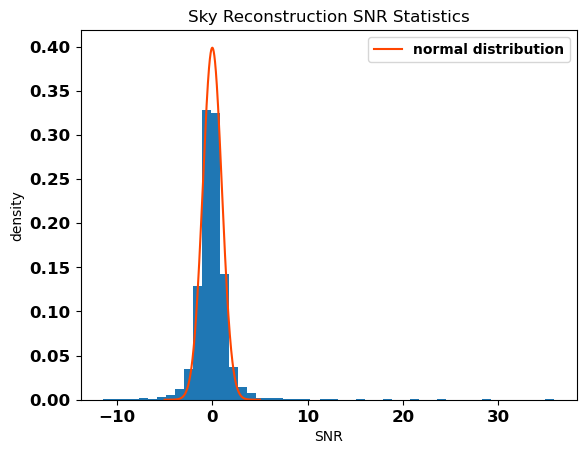

In [20]:
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.hist(snr.reshape(-1), bins=50, density= True)
plt.plot(x := np.linspace(-5, 5, 1000), norm.pdf(x), color="OrangeRed", label="normal distribution")
plt.title("Sky Reconstruction SNR Statistics")
plt.xlabel("SNR")
plt.ylabel("density")
plt.legend()
plt.show()

- If now one wants to search for outliers (e.g. the sources) with SNR over $k\sigma$ threshold:

In [37]:
k = 25
peaks_pos = np.argwhere(snr > k).T
peaks_snr_values = snr[*peaks_pos]

print(f"\n# of simulated sources: {len(sources_flux)}"
      f"\n# of outliers with SNR(σ) over {k}: {len(peaks_pos[0])}")


# of simulated sources: 3
# of outliers with SNR(σ) over 25: 9


- now I take the most significant source and build a shadowgram for it

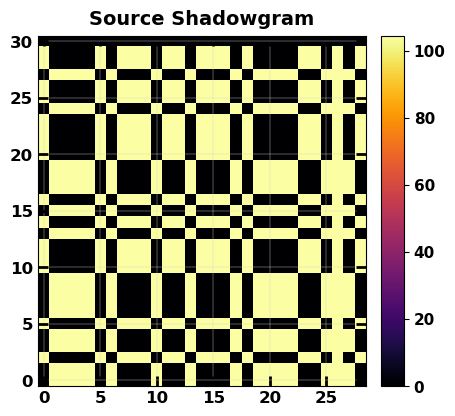

In [47]:
def shadowgram(pos: tuple, counts: int):

    s = np.zeros(sky_shape)
    s[*pos] = counts
    s_d_img = correlate(mask, s, mode='full')[2*h : -2*h, 2*v : -2*v]

    assert s_d_img.shape == fcfov_detector_image.shape

    return s_d_img



higher_snr = peaks_snr_values.max()
loc = np.argwhere(snr == higher_snr).T

source_shadowgram = shadowgram(loc, bal_sky_reconstruction[*loc])

plot.image_plot([source_shadowgram],
                [f"Source Shadowgram"],
                cbarcmap=["inferno"])

- Now let's subtract this shadowgram to the detector image and decode the result

/tmp/ipykernel_26521/1170369742.py:10: RuntimeWarning: invalid value encountered in sqrt
  iros1_snr = iros1_sky_reconstruction/np.sqrt(iros1_balskyrec_var + 1e-8)


IROS1_S_hat[0] - S[0]: 0.22005408923863
IROS1_STD_S_hat[0]: 2.875256826577744

IROS1_S_hat[1] - S[1]: -101.00000000000045
IROS1_STD_S_hat[1]: 2.8753448025284287

IROS1_S_hat[2] - S[2]: 0.5070375091834478
IROS1_STD_S_hat[2]: 2.8752583009120163



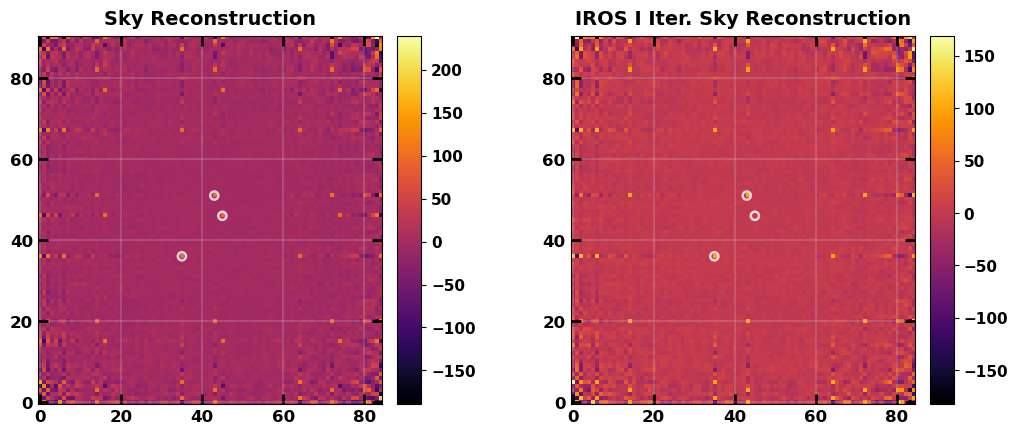

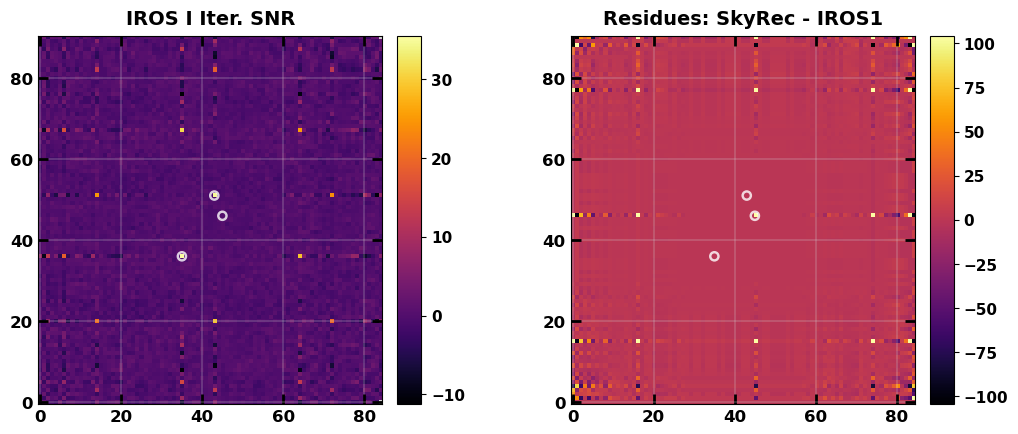

In [49]:
iros1_detector_image = fcfov_detector_image - source_shadowgram

iros1_sky_reconstruction, iros1_balskyrec_var = balancing.balanced_sky_reconstruction(iros1_detector_image)

threshold = 300
post_iros1_sky_reconstruction = iros1_sky_reconstruction.copy()
post_iros1_sky_reconstruction[iros1_sky_reconstruction > threshold] = 0     # remove artifacts
post_iros1_sky_reconstruction[iros1_sky_reconstruction < -threshold] = 0

iros1_snr = iros1_sky_reconstruction/np.sqrt(iros1_balskyrec_var + 1e-8)

for idx, pos in enumerate(sources_pos):
    print(f"IROS1_S_hat[{idx}] - S[{idx}]: {iros1_sky_reconstruction[*pos] - sky_image[*pos]}\n"
          f"IROS1_STD_S_hat[{idx}]: {np.sqrt(iros1_balskyrec_var[*pos])}\n")

plot.image_plot([post_bal_sky_reconstruction, post_iros1_sky_reconstruction],
                ["Sky Reconstruction", "IROS I Iter. Sky Reconstruction"],
                cbarcmap=["inferno"]*2,
                simulated_sources=[sources_pos, sources_pos])

plot.image_plot([iros1_snr, post_bal_sky_reconstruction - post_iros1_sky_reconstruction],
                ["IROS I Iter. SNR", "Residues: SkyRec - IROS1"],
                cbarcmap=["inferno"]*2,
                simulated_sources=[sources_pos, sources_pos])

**Second Iteration**

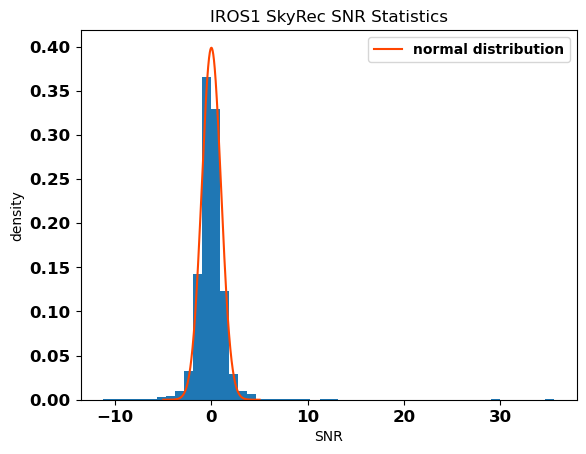

In [50]:
plt.hist(iros1_snr.reshape(-1), bins=50, density= True)
plt.plot(x := np.linspace(-5, 5, 1000), norm.pdf(x), color="OrangeRed", label="normal distribution")
plt.title("IROS1 SkyRec SNR Statistics")
plt.xlabel("SNR")
plt.ylabel("density")
plt.legend()
plt.show()


# of outliers with SNR(σ) over 25: 6


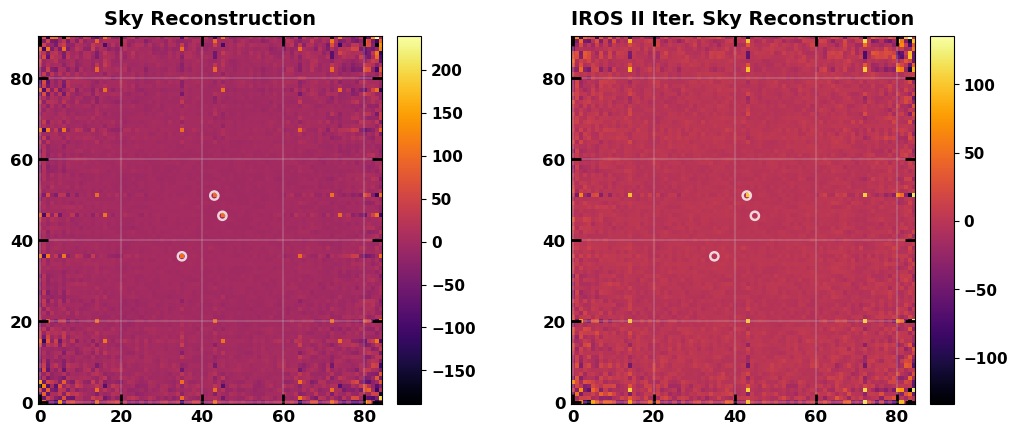

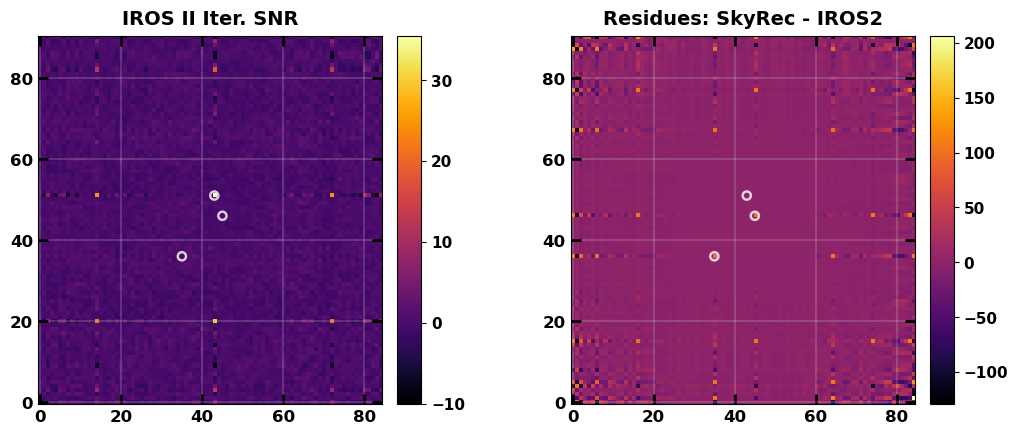

In [59]:
k = 25
peaks_pos = np.argwhere(iros1_snr > k).T
peaks_snr_values = iros1_snr[*peaks_pos]

print(f"\n# of outliers with SNR(σ) over {k}: {len(peaks_pos[0])}")

higher_snr = peaks_snr_values.max()
loc = np.argwhere(iros1_snr == higher_snr).T

source_shadowgram = shadowgram(loc, iros1_sky_reconstruction[*loc])

iros2_detector_image = iros1_detector_image - source_shadowgram

iros2_sky_reconstruction, iros2_balskyrec_var = balancing.balanced_sky_reconstruction(iros2_detector_image)

threshold = 300
post_iros2_sky_reconstruction = iros2_sky_reconstruction.copy()
post_iros2_sky_reconstruction[iros2_sky_reconstruction > threshold] = 0     # remove artifacts
post_iros2_sky_reconstruction[iros2_sky_reconstruction < -threshold] = 0

iros2_snr = iros2_sky_reconstruction/np.sqrt(iros2_balskyrec_var + 1e-8)

plot.image_plot([post_bal_sky_reconstruction, post_iros2_sky_reconstruction],
                ["Sky Reconstruction", "IROS II Iter. Sky Reconstruction"],
                cbarcmap=["inferno"]*2,
                simulated_sources=[sources_pos, sources_pos])

plot.image_plot([iros2_snr, post_bal_sky_reconstruction - post_iros2_sky_reconstruction],
                ["IROS II Iter. SNR", "Residues: SkyRec - IROS2"],
                cbarcmap=["inferno"]*2,
                simulated_sources=[sources_pos, sources_pos])

**Third Iteration**

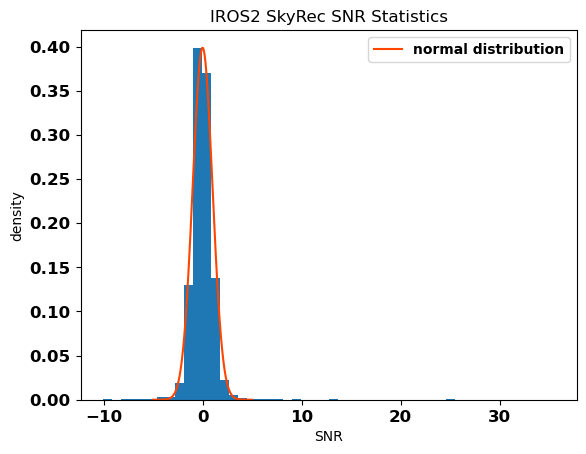

In [60]:
plt.hist(iros2_snr.reshape(-1), bins=50, density= True)
plt.plot(x := np.linspace(-5, 5, 1000), norm.pdf(x), color="OrangeRed", label="normal distribution")
plt.title("IROS2 SkyRec SNR Statistics")
plt.xlabel("SNR")
plt.ylabel("density")
plt.legend()
plt.show()


# of outliers with SNR(σ) over 25: 2


/tmp/ipykernel_26521/4179493638.py:21: RuntimeWarning: invalid value encountered in sqrt
  iros3_snr = iros3_sky_reconstruction/np.sqrt(iros3_balskyrec_var + 1e-8)


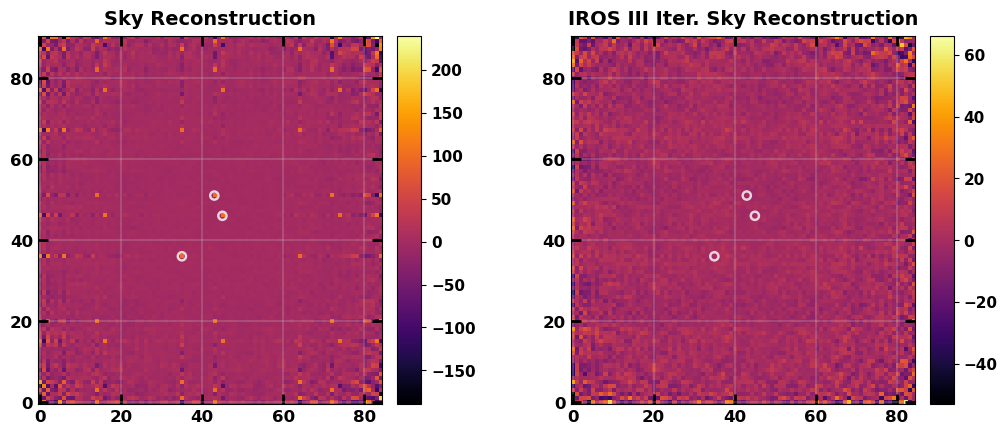

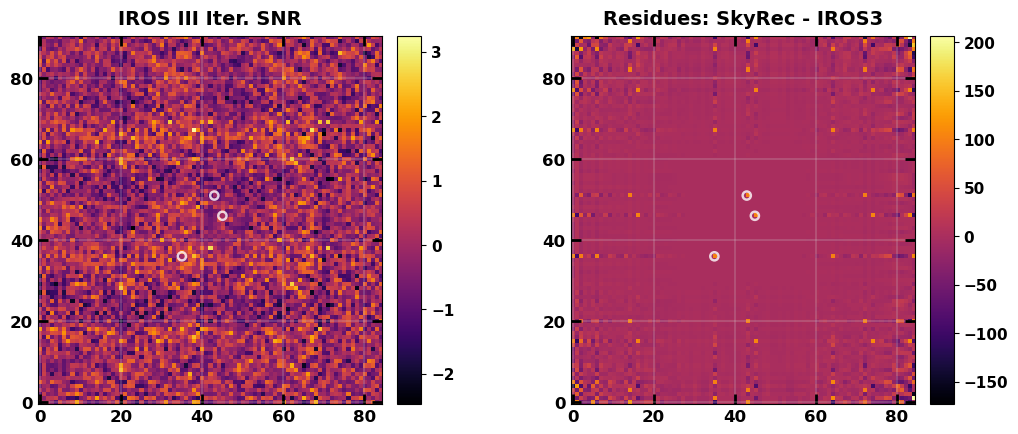

In [61]:
k = 25
peaks_pos = np.argwhere(iros2_snr > k).T
peaks_snr_values = iros2_snr[*peaks_pos]

print(f"\n# of outliers with SNR(σ) over {k}: {len(peaks_pos[0])}")

higher_snr = peaks_snr_values.max()
loc = np.argwhere(iros2_snr == higher_snr).T

source_shadowgram = shadowgram(loc, iros2_sky_reconstruction[*loc])

iros3_detector_image = iros2_detector_image - source_shadowgram

iros3_sky_reconstruction, iros3_balskyrec_var = balancing.balanced_sky_reconstruction(iros3_detector_image)

threshold = 300
post_iros3_sky_reconstruction = iros3_sky_reconstruction.copy()
post_iros3_sky_reconstruction[iros3_sky_reconstruction > threshold] = 0     # remove artifacts
post_iros3_sky_reconstruction[iros3_sky_reconstruction < -threshold] = 0

iros3_snr = iros3_sky_reconstruction/np.sqrt(iros3_balskyrec_var + 1e-8)

plot.image_plot([post_bal_sky_reconstruction, post_iros3_sky_reconstruction],
                ["Sky Reconstruction", "IROS III Iter. Sky Reconstruction"],
                cbarcmap=["inferno"]*2,
                simulated_sources=[sources_pos, sources_pos])

plot.image_plot([iros3_snr, post_bal_sky_reconstruction - post_iros3_sky_reconstruction],
                ["IROS III Iter. SNR", "Residues: SkyRec - IROS3"],
                cbarcmap=["inferno"]*2,
                simulated_sources=[sources_pos, sources_pos])

- In this simple case IROS managed to remove the sources by considering the max value of the SNR

- However, if the fluxes from the sources are not the same, this approach may become more complex, since there is also the effect of the PCFOV (i.e. of the brightest ghost peaks, even without sources in this zone)

- If the SNR from a FCFOV source ghost peak is higher than the SNR of a proper source (always in the FCFOV), the iteration will be applied to this ghost peak and not to the true source

**Sky Image Reconstruction**

- Let's look at the true sources and at the reconstructed ones

In [68]:
rec_sources_counts = []

for idx, pos in enumerate(sources_pos):
    print(
        f"Source S[{idx}] counts: {sky_image[*pos]:.0f}\n"
        f"Reconstructed Source S_hat[{idx}] counts: {bal_sky_reconstruction[*pos]:.0f} +/- {np.sqrt(balskyrec_var[*pos]):.0f}\n"
    )
    rec_sources_counts.append(bal_sky_reconstruction[*pos])

Source S[0] counts: 102
Reconstructed Source S_hat[0] counts: 102 +/- 3

Source S[1] counts: 101
Reconstructed Source S_hat[1] counts: 104 +/- 3

Source S[2] counts: 100
Reconstructed Source S_hat[2] counts: 100 +/- 3



In [83]:
# the sky background rate can be estimated by subtracting the total detector counts and the sum of the counts from the recovered sources

open_fraction = ura_pattern2D.sum()/np.prod(ura_pattern2D.shape)
estim_sky_bg_rate = open_fraction*(fcfov_detector_image.sum()/ura_pattern2D.sum() - sum(rec_sources_counts))/(n*m)  # include normalization

print(
    f"True sky background rate: {sky_background_rate}\n"
    f"Estimated sky background flux counts per mask element: {estim_sky_bg_rate:.0f} +/- {np.sqrt(estim_sky_bg_rate):.0f}"
    )

True sky background rate: 1
Estimated sky background flux counts per mask element: 2 +/- 1


- After the third iteration, the resulting image should give an estimation of the sky background

- Let's see how the values in the sky after the source removal are distribuited

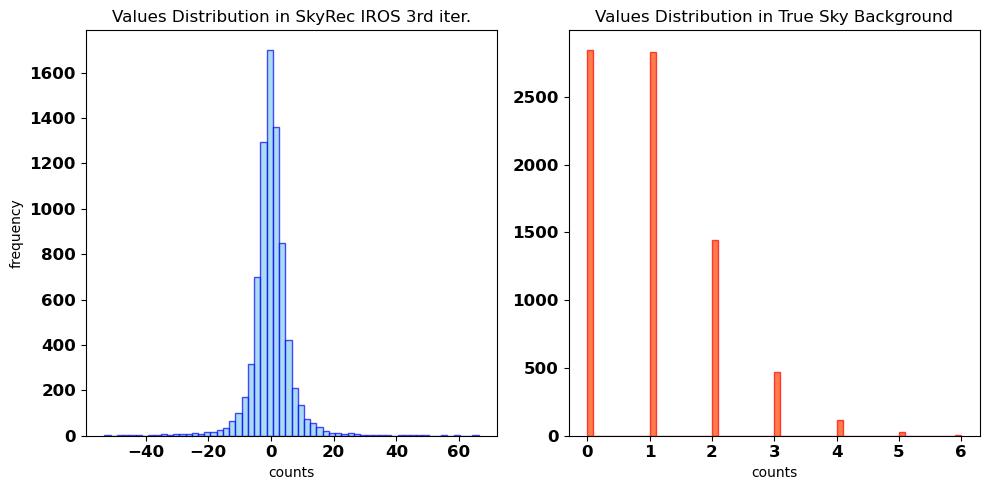

In [ ]:
nbins = 60


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].hist(post_iros3_sky_reconstruction.reshape(-1), bins=nbins,
             color='SkyBlue', edgecolor='b', alpha=0.7)
axes[0].set_title('Values Distribution in SkyRec IROS 3rd iter.')
axes[0].set_xlabel('counts')
axes[0].set_ylabel('frequency')

axes[1].hist(sky_background.reshape(-1), bins=nbins, color='OrangeRed',
             edgecolor='r', alpha=0.7)
axes[1].set_title('Values Distribution in True Sky Background')
axes[1].set_xlabel('counts')

plt.tight_layout()
plt.show()

### **Sky Image with Sources also in the PCFOV**